In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
metrics = ["model2.csv", "model3.csv", "model4.csv", "model5.csv"]
dfs = []

for metric in metrics: 
    file = "../saved/metrics/" + metric
    df = pd.read_csv(file)
    dfs.append(df.copy())

df = pd.concat(dfs)

In [26]:
def get_final(x): 
    train_accs = [float(x) for x in x[1: -1].split(",")] 
    return train_accs[-1]

def convert(x): 
    return np.array([float(x) for x in x[1: -1].split(",")])

df["train_acc"] = df["smooth_acc"].apply(lambda x: get_final(x))
df["convert_train"] = df["smooth_acc"].apply(lambda x: convert(x))
df["convert_train_steps"] = df["step"].apply(lambda x: convert(x))

df["convert_val"] = df["val_acc"].apply(lambda x: convert(x))
df["convert_val_steps"] = df["val_step"].apply(lambda x: convert(x))

In [27]:
df.groupby(["lr","penalty"])["final_acc"].mean().unstack()

penalty,0.0,10.0,100.0,1000.0,10000.0
lr,,,,,
0.00001,0.648317,0.685928,0.719317,0.571106,0.161444
0.00010,0.963317,0.941128,0.961456,0.948428,0.782511
0.00100,0.948606,0.880111,0.963994,0.976278,0.966989
0.01000,0.109061,0.185172,0.113444,0.216433,0.226917


In [12]:
df = df[df["lr"] == 0.001]

In [20]:
df[df["penalty"] == 1000]

,Unnamed: 0,acc,final_acc,loss,lr,name,penalty,smooth_acc,step,val_acc,val_step,train_acc,convert_train,convert_train_steps,convert_val,convert_val_steps
15,15,"[0.234375, 0.015625, 0.140625, 0.125, 0.171875...",0.961194,"[4.229459285736084, 5.302126407623291, 4.33819...",0.001,model3_penalty_1000.0_lr_0.001,1000.0,"[0.234375, 0.125, 0.13020833333333334, 0.12890...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0.10566666666666667, 0.9072777777777777, 0.95...","[0, 657, 1314, 1971, 2628, 3285, 3942, 4599, 5...",0.924531,"[0.234375, 0.125, 0.13020833333333334, 0.12890...","[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, ...","[0.10566666666666667, 0.9072777777777777, 0.95...","[0.0, 657.0, 1314.0, 1971.0, 2628.0, 3285.0, 3..."
16,16,"[0.140625, 0.125, 0.03125, 0.15625, 0.078125, ...",0.979056,"[8.333662033081055, 4.733268737792969, 4.78896...",0.001,model3_penalty_1000.0_lr_0.001,1000.0,"[0.140625, 0.1328125, 0.09895833333333333, 0.1...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0.09616666666666666, 0.9093611111111111, 0.95...","[0, 657, 1314, 1971, 2628, 3285, 3942, 4599, 5...",0.986094,"[0.140625, 0.1328125, 0.09895833333333333, 0.1...","[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, ...","[0.09616666666666666, 0.9093611111111111, 0.95...","[0.0, 657.0, 1314.0, 1971.0, 2628.0, 3285.0, 3..."
17,17,"[0.125, 0.046875, 0.109375, 0.109375, 0.046875...",0.979833,"[14.234224319458008, 4.830740928649902, 4.6368...",0.001,model3_penalty_1000.0_lr_0.001,1000.0,"[0.125, 0.0859375, 0.09375, 0.09765625, 0.0875...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0.0761388888888889, 0.92075, 0.95688888888888...","[0, 657, 1314, 1971, 2628, 3285, 3942, 4599, 5...",0.986250,"[0.125, 0.0859375, 0.09375, 0.09765625, 0.0875...","[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, ...","[0.0761388888888889, 0.92075, 0.95688888888888...","[0.0, 657.0, 1314.0, 1971.0, 2628.0, 3285.0, 3..."
18,18,"[0.125, 0.15625, 0.109375, 0.03125, 0.125, 0.0...",0.980528,"[4.801340103149414, 5.480985164642334, 4.75398...",0.001,model3_penalty_1000.0_lr_0.001,1000.0,"[0.125, 0.140625, 0.13020833333333334, 0.10546...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0.09938888888888889, 0.9385277777777777, 0.95...","[0, 657, 1314, 1971, 2628, 3285, 3942, 4599, 5...",0.987031,"[0.125, 0.140625, 0.13020833333333334, 0.10546...","[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, ...","[0.09938888888888889, 0.9385277777777777, 0.95...","[0.0, 657.0, 1314.0, 1971.0, 2628.0, 3285.0, 3..."
19,19,"[0.15625, 0.03125, 0.125, 0.15625, 0.21875, 0....",0.980778,"[12.08480453491211, 4.792882919311523, 4.80097...",0.001,model3_penalty_1000.0_lr_0.001,1000.0,"[0.15625, 0.09375, 0.10416666666666667, 0.1171...","[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, ...","[0.09463888888888888, 0.9297777777777778, 0.95...","[0, 657, 1314, 1971, 2628, 3285, 3942, 4599, 5...",0.983906,"[0.15625, 0.09375, 0.10416666666666667, 0.1171...","[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0, 4.0, ...","[0.09463888888888888, 0.9297777777777778, 0.95...","[0.0, 657.0, 1314.0, 1971.0, 2628.0, 3285.0, 3..."


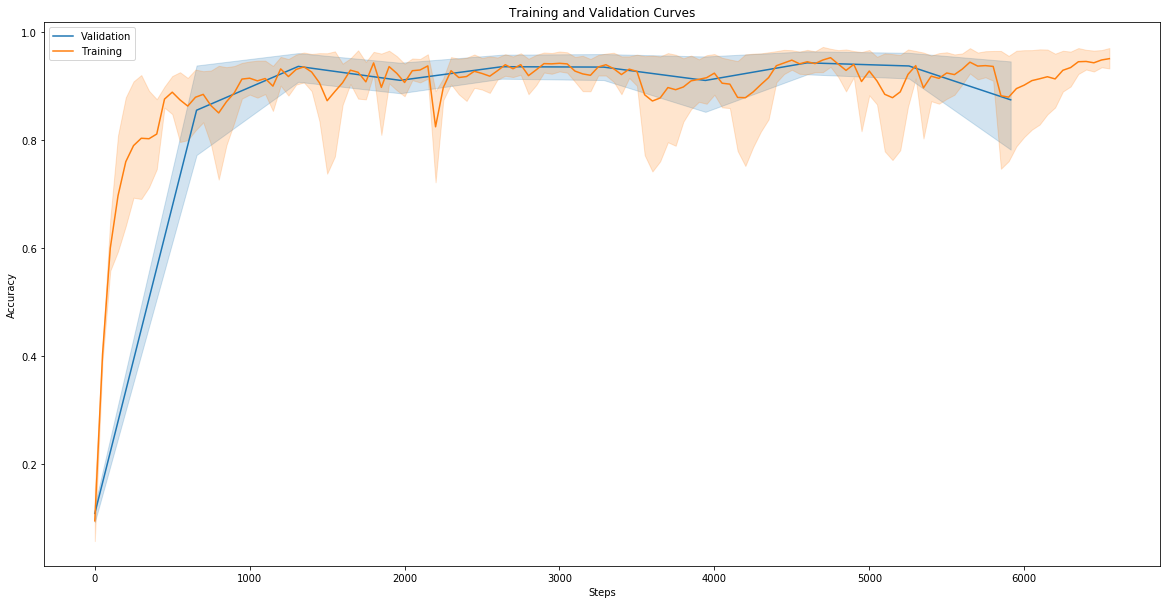

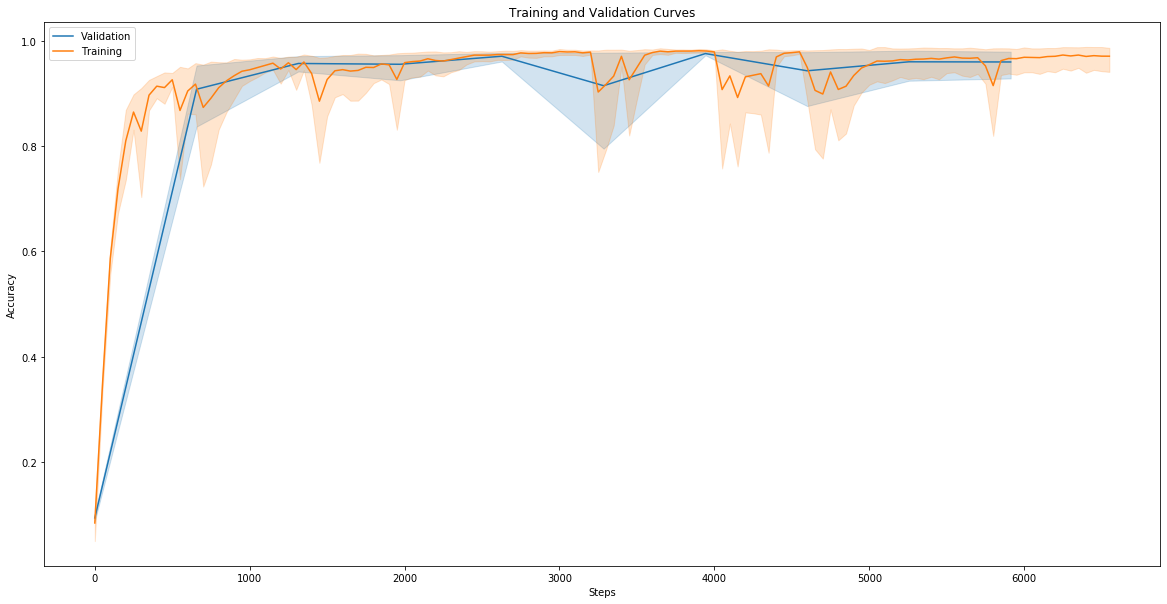

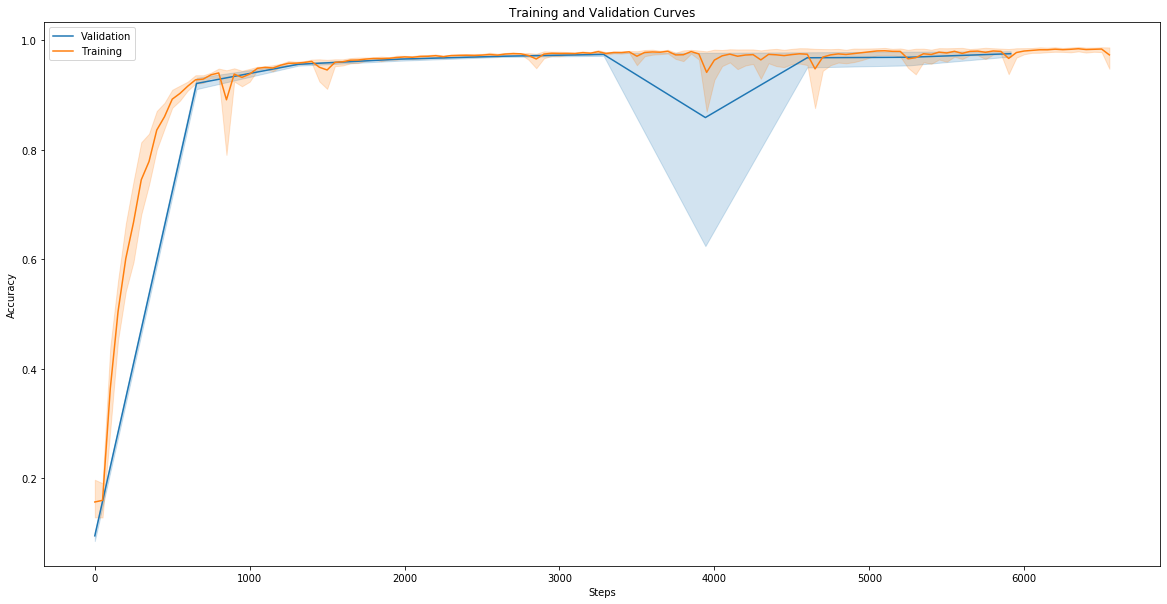

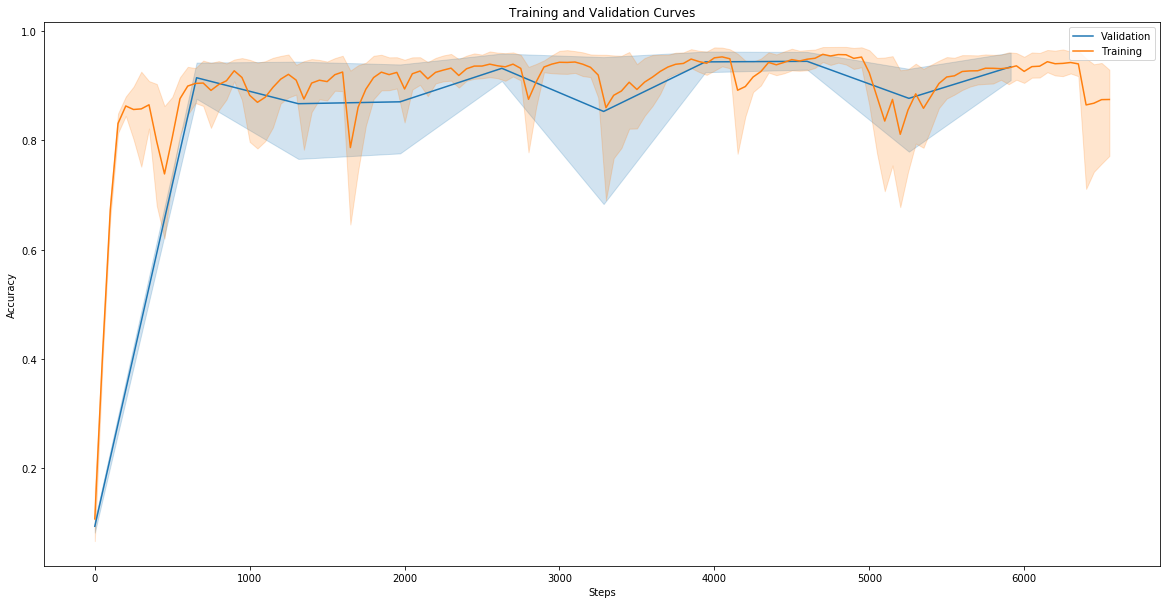

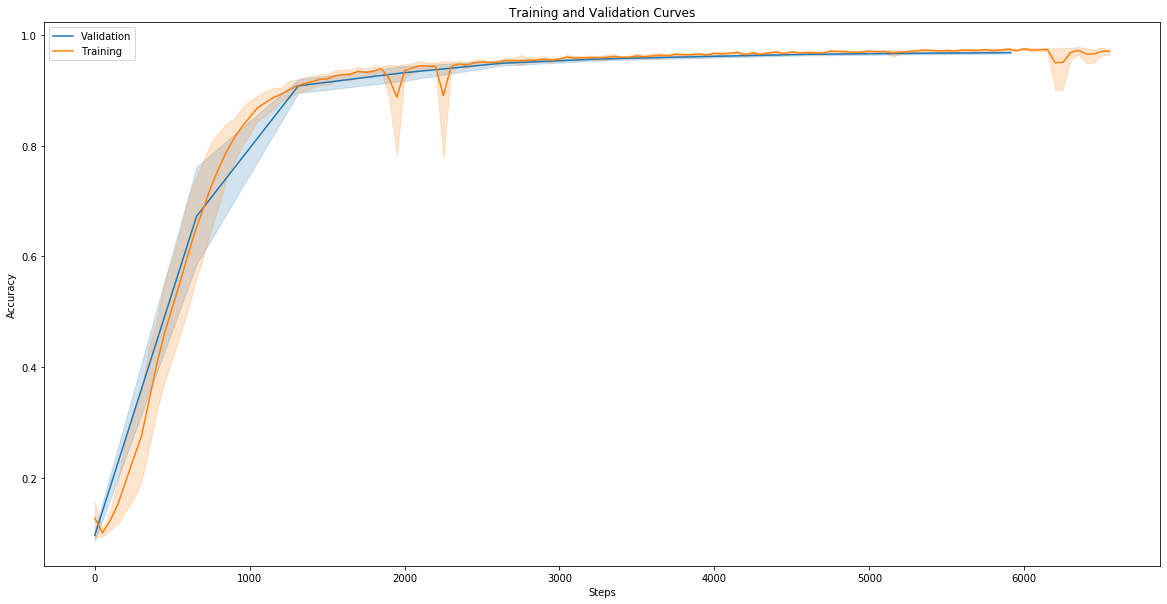

In [13]:
def format_lineplot(metric, steps = None, every = 1):
    dflist = []
    for m in metric:
        if steps is None: 
            steps = np.arange(len(m))
        dflist.append(pd.DataFrame({"step": np.array(steps)[::every], "metric": np.array(m)[::every]}))
    df_comp = pd.concat(dflist)
    return df_comp


for penalty in set(df["penalty"]):
    plt.figure(figsize=(20, 10))
    vals = np.array(df[df["penalty"]==penalty]["convert_val"])
    val_steps = np.array(df[df["penalty"]==penalty]["convert_val_steps"])
    val_df = format_lineplot(vals, val_steps[0])
    
    trains = np.array(df[df["penalty"]==penalty]["convert_train"])
    train_steps = np.array(df[df["penalty"]==penalty]["convert_train_steps"])
    train_df = format_lineplot(trains, train_steps[0], every = 100)
    
    sns.lineplot(data = val_df, x = "step", y = "metric", label = "Validation")
    sns.lineplot(data = train_df, x = "step", y = "metric", label = "Training")
    
    plt.title("Training and Validation Curves")
    plt.xlabel("Steps")
    plt.ylabel("Accuracy")
    plt.legend()
#     plt.savefig("plots/curves_%s.svg"%(penalty))

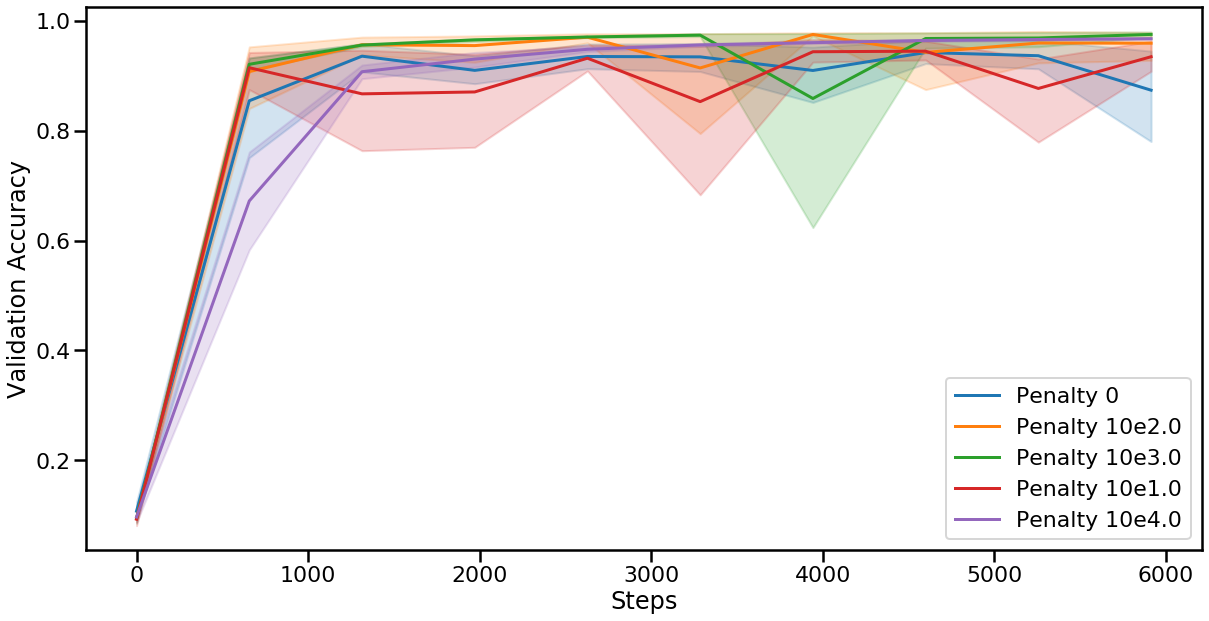

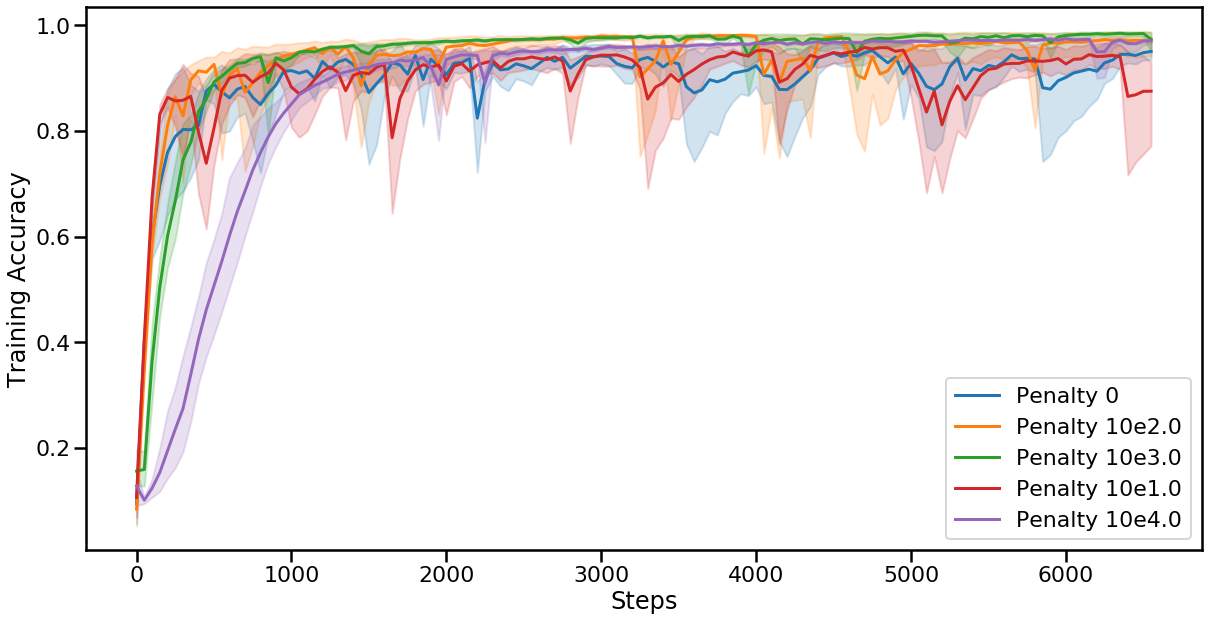

In [14]:
sns.set_context("poster")
plt.figure(figsize=(20, 10))
for penalty in set(df["penalty"]):
    vals = np.array(df[df["penalty"]==penalty]["convert_val"])
    val_steps = np.array(df[df["penalty"]==penalty]["convert_val_steps"])
    val_df = format_lineplot(vals, val_steps[0])
    
    if penalty != 0:
        p = "10e%s"%np.log10(penalty)
    else: 
        p = 0
    sns.lineplot(data = val_df, x = "step", y = "metric", label = "Penalty %s"%p)
    plt.xlabel("Steps")
    plt.ylabel("Validation Accuracy")
    

sns.set_context("poster")
plt.figure(figsize=(20, 10))
for penalty in set(df["penalty"]):
    trains = np.array(df[df["penalty"]==penalty]["convert_train"])
    train_steps = np.array(df[df["penalty"]==penalty]["convert_train_steps"])
    train_df = format_lineplot(trains, train_steps[0], every = 100)
    
    if penalty != 0:
        p = "10e%s"%np.log10(penalty)
    else: 
        p = 0
    sns.lineplot(data = train_df, x = "step", y = "metric", label = "Penalty %s"%p)
    plt.xlabel("Steps")
    plt.ylabel("Training Accuracy")

(0.8, 1.0)

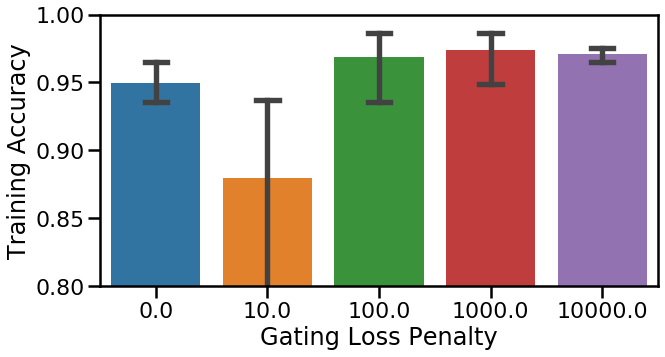

In [15]:
plt.figure(figsize = (10, 5))
sns.set_context("poster")
# sns.set()
sns.barplot(data = df, x = "penalty", y = "train_acc", capsize=.2)
plt.xlabel("Gating Loss Penalty")
plt.ylabel("Training Accuracy")
plt.ylim([0.8, 1.0])

Text(0, 0.5, 'Validation Accuracy')

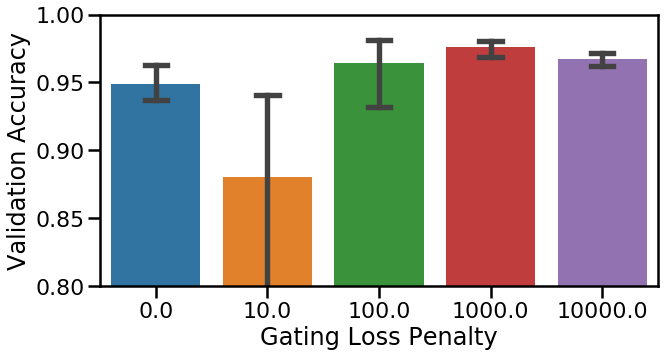

In [22]:
plt.figure(figsize = (10, 5))
sns.barplot(data = df, x = "penalty", y = "final_acc", capsize=.2)
plt.xlabel("Gating Loss Penalty")
plt.ylim([0.8, 1.0])
plt.ylabel("Validation Accuracy")

# plt.savefig("plots/val_boxplot.svg")